<a href="https://colab.research.google.com/github/VindhyaSRajan/Master-s-Thesis/blob/master/Copy_of_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install gensim
!pip install warnings
!pip install pyLDAvis

In [0]:
import pandas as pd
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
import nltk
nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

##Loading the raw data

In [0]:
df_garden = pd.read_csv('/content/drive/My Drive/Amazon_data/reviews_Patio_Lawn_And_Garden.csv', error_bad_lines= False , nrows= 100000)
df_garden.shape

(100000, 9)

In [0]:
df_garden.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2VNYWOPJ13AFP,0981850006,"Amazon Customer ""carringt0n""","[6, 7]",This was a gift for my other husband. He's ma...,5.0,Delish,1259798400,"12 3, 2009"
1,A20DWVV8HML3AW,0981850006,Cyndy,"[0, 0]","My husband rarely asks for anything specific, ...",5.0,Just what my husband wanted,1371081600,"06 13, 2013"
2,A3RVP3YBYYOPRH,0981850006,John Warren,"[9, 11]",This guy knows his stuff. I love the seriously...,5.0,Love This Show!,1257984000,"11 12, 2009"
3,A28XY55TP3Q90O,0981850006,"JSG ""Lover of Learning""","[1, 1]","THIS CAN BE FOUND AT: [...] FOR $19.99, also a...",5.0,"BUY ELSEWHERE, TOO EXPENSIVE",1314144000,"08 24, 2011"
4,A3VZW1BGUQO0V3,0981850006,"Marc G. Belisle ""Allswell2001""","[2, 2]",Quite good particularly for inspiration (DVD g...,5.0,Quite good but I *much* prefer the cookbooks,1308268800,"06 17, 2011"


##Pre-processing the reviewText 

In [0]:
# Convert to array
docs =array(df_garden['reviewText'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
100000
Number of unique tokens: 17697
Number of documents: 100000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]


In [0]:
type(corpus)

list

##LDA on the ReviewText Column of the Amazon Data

In [0]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.054*"product" + 0.016*"would_recommend" + 0.014*"feeder" + 0.013*"recommend" + 0.012*"item" + 0.012*"amazon" + 0.012*"well_made" + 0.010*"better_than" + 0.010*"from" + 0.009*"been_using"'), (1, '0.018*"trap" + 0.014*"them" + 0.014*"mouse" + 0.012*"plant" + 0.009*"grill" + 0.009*"these" + 0.007*"house" + 0.007*"keep" + 0.007*"love" + 0.007*"table"'), (2, '0.015*"time" + 0.015*"year" + 0.013*"after" + 0.012*"more" + 0.012*"will" + 0.011*"about" + 0.010*"only" + 0.010*"bought" + 0.009*"water" + 0.009*"from"'), (3, '0.018*"yard" + 0.013*"grass" + 0.012*"battery" + 0.011*"look_like" + 0.010*"light_weight" + 0.009*"fence" + 0.009*"leaf" + 0.008*"power" + 0.008*"burner" + 0.007*"about_minute"'), (4, '0.016*"good" + 0.016*"easy" + 0.011*"like" + 0.008*"handle" + 0.008*"need" + 0.008*"little" + 0.008*"make" + 0.008*"your" + 0.007*"tool" + 0.007*"what"')]


In [17]:
#This code block is to see as a data frame what each topic actually comprises of.
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,husband,hatchet,time,soil,well_worth,make_sure,will,trap,them,easy,cover,burner,product,snow,quality,water,highly_recommend,than,feeder,grill
1,outdoor,tree,year,grass,bug,wood,from,mouse_trap,these,light,pool,grow,what,very_pleased,worry_about,hose,peanut_butter,more_than,bird,table
2,propane,chain,used,blade,rather_than,minute,like,flea,mouse,sprinkler,head,highly_recommended,price,inch,brand,battery,highly,well_made,seed,food
3,morning,yard,about,leaf,after_reading,instruction,when,house,plant,last_year,long,recommended,would_recommend,spring,expensive,spray,company,better_than,heavy_duty,much_better
4,replaced,edge,after,sharp,ant,sure,more,bait,garden,light_weight,last_long,home_depot,recommend,built,steel,metal_detector,replacement,very_happy,much_easier,smoker
5,propane_tank,file,bought,lawn,animal,peanut,your,night,squirrel,even_though,replace,home,item,bulb,high_quality,winter,butter,le_than,easier,chicken
6,small_amount,back_yard,were,blower,reading,hour,some,snap_trap,caught_mouse,deer,catch,tank,look,well_built,stainless_steel,stick,know_what,le,watering,meat
7,everyone,turkey,first,cast_iron,cleaning,about_minute,other,kill,dead_mouse,weight,rain,feel_like,amazon,pleased,more_expensive,detector,recommend,more,gift,charcoal
8,very_impressed,trimmer,been,power,pack,direction,good,dog,cat,easy_clean,color,insect,perfect,could_find,broke,advertised,part,better,heavy,temperature
9,past_year,pruner,back,shovel,charge,cooking,little,door,deck,easy_assemble,other_reviewer,patio,good,should_last,original,sprayer,base,amount,wind,black_decker


##Evaluating the LDA Model

In [0]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3268774180076323


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

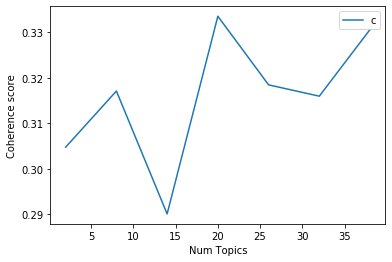

<Figure size 432x288 with 0 Axes>

In [0]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics- Review_Text', dpi = 500)

##Pre-processing the Summary column of the AMazon Dataset

In [0]:
# Convert to array
docs =array(df_garden['summary'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
100000
Number of unique tokens: 3085
Number of documents: 100000
[[]]


##LDA on the Summary column of the Amazon Dataset

In [0]:
# Set parameters.
num_topics = 30 #changed from 5 to 30 based on the coherence score graph
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 30 topics
print(lda_model.print_topics())

[(26, '0.140*"used" + 0.074*"easy_assemble" + 0.072*"fit" + 0.061*"soil" + 0.050*"again" + 0.049*"fit_perfectly" + 0.046*"green" + 0.031*"camping" + 0.030*"beat" + 0.028*"side"'), (5, '0.167*"time" + 0.087*"first" + 0.086*"replacement" + 0.053*"get_done" + 0.048*"part" + 0.041*"first_time" + 0.037*"get" + 0.037*"will_tell" + 0.035*"done" + 0.033*"fell_apart"'), (15, '0.270*"five_star" + 0.126*"star" + 0.098*"five" + 0.097*"need" + 0.052*"long" + 0.048*"last" + 0.028*"find" + 0.028*"hard" + 0.021*"long_time" + 0.018*"assemble"'), (8, '0.306*"excellent" + 0.058*"fine" + 0.054*"useful" + 0.035*"solution" + 0.035*"arrived" + 0.031*"insect" + 0.026*"natural" + 0.024*"poorly_made" + 0.022*"pole" + 0.021*"poorly"'), (2, '0.171*"awesome" + 0.084*"fence" + 0.057*"fast" + 0.042*"gift" + 0.041*"shipping" + 0.039*"fast_shipping" + 0.038*"rabbit" + 0.035*"another" + 0.031*"deck" + 0.030*"gilmour"'), (22, '0.263*"price" + 0.077*"junk" + 0.071*"solid" + 0.071*"away" + 0.043*"very_pleased" + 0.032*"pl

In [0]:
#This code block is to see as a data frame what each topic actually comprises of.
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30
0,stuff,poor_quality,awesome,effective,grill,time,feeder,tool,excellent,really,perfect,this,product,quality,these,five_star,have,mouse,mouse_trap,very,with,best,price,table,good,love,used,your,great,work
1,cheap,poor,fence,smoker,more,first,bird,worked,fine,worth_money,just,sprinkler,like,better_than,they,star,plant,design,trap,nice,easy,ever,junk,year,trowel,what,easy_assemble,small,must_have,well
2,save_your,amazing,fast,item,pool,replacement,bird_feeder,light,useful,high_quality,just_what,house,money,better,value,five,that,from,little,sturdy,look,will,solid,after,water,exactly_what,fit,waste_your,must,doe
3,super,fiskars,gift,pretty,metal,get_done,hose,wonderful,solution,garden,made,chair,waste_money,than,heavy_duty,need,should,much_better,much,happy,simple,needed,away,burner,plastic,worth,soil,keep,purchase,doesn
4,pruner,blower,shipping,seed,watering,part,didn,light_weight,arrived,thing,well_made,outdoor,like_charm,cover,advertised,long,four_star,amazon,customer_service,right,well_built,would,very_pleased,classic,perfectly,exactly,again,ever_used,trimmer,only
5,grass,home,fast_shipping,food,idea,first_time,deer,yard,insect,high,what,kill,them,better_mousetrap,review,last,should_have,umbrella,service,happy_with,tree,bought,pleased,strong,proof,disappointed,fit_perfectly,inch,back,other
6,sharp,black_decker,rabbit,piece,snow,get,problem,recommend,natural,what_expected,well,nothing,never,mousetrap,heavy,find,some,le_than,enough,just_right,impressed,handy,chicken,seems,time_saver,loved,green,waste,wood,described
7,hand,poor_design,another,shovel,cooker,will_tell,squirrel,without,poorly_made,worth,deal,system,make,when,worth_every,hard,snap,second,could,catch,built,looking,thought,still,saved,killer,camping,handle,dont,horrible
8,save,chain,deck,made_china,more_than,done,fantastic,leak,pole,money,terrible,over,waste,control,smell,long_time,there,lawn,customer,safe,decent,accessory,powerful,working,color,something_else,beat,large,through,wish
9,electric,power,gilmour,piece_junk,camp,fell_apart,size,pest,poorly,expected,weight,day,tire,stand,duty,assemble,easy_together,mower,wrong,take,line,help,pet,life,concept,nothing_else,side,result,careful,before


##Evaluating the LDA Model

In [0]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda) #Coherence score on 5 topics was 0.38654120411864723


Coherence Score:  0.5476230779194542


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

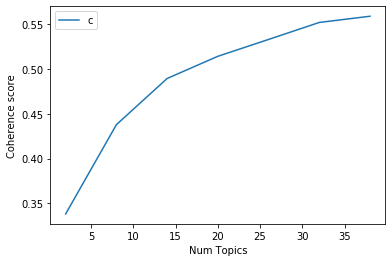

<Figure size 432x288 with 0 Axes>

In [0]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics - Summary', dpi = 500)

##Now Working on the Meta-Data of Amazon. This is to check if the LDA works better on the category data

In [0]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
df_meta = getDF('/content/drive/My Drive/Amazon_data/meta_Patio_Lawn_and_Garden.json.gz')

In [0]:
df_meta.shape #should be (279697, 18)
df_meta.head()
df_meta.columns
#type(df_meta.category)

Index(['category', 'tech1', 'description', 'title', 'also_buy', 'brand',
       'feature', 'rank', 'main_cat', 'date', 'price', 'asin', 'image',
       'also_view', 'similar_item', 'details', 'fit', 'tech2'],
      dtype='object')

In [0]:
df_meta.to_csv('Amazon_Meta_Data_LawnAndGarden.csv')
!cp Amazon_Meta_Data_LawnAndGarden.csv /content/drive/My Drive/Amazon_data

cp: target 'Drive/Amazon_data' is not a directory


##Pre-processing of the meta data

In [0]:
# Convert to array
docs =array(df_meta['category'].astype(str))
print(type(docs))
print(len(docs))
# Define function for tokenize and lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)
#Create Biagram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
#Remove rare & common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

<class 'numpy.ndarray'>
279697
Number of unique tokens: 878
Number of documents: 279697
[[(0, 1), (1, 2), (2, 1), (3, 1)]]


##LDA Implementation

In [0]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.122*"cooking" + 0.113*"furniture" + 0.107*"grill" + 0.043*"farm" + 0.043*"ranch" + 0.034*"agricultural" + 0.033*"construction" + 0.033*"machinery" + 0.030*"umbrella" + 0.028*"seating"'), (1, '0.072*"hand" + 0.059*"yard" + 0.046*"sign" + 0.039*"chime" + 0.038*"support" + 0.037*"structure" + 0.035*"poultry" + 0.033*"plant" + 0.032*"porch_swing" + 0.030*"cooling"'), (2, '0.302*"part" + 0.179*"replacement" + 0.116*"mower" + 0.107*"power" + 0.050*"statue" + 0.038*"sculpture" + 0.016*"decorative" + 0.012*"canopy" + 0.012*"birding" + 0.012*"wildlife"'), (3, '0.126*"plant" + 0.116*"bulb" + 0.115*"seed" + 0.069*"flag" + 0.051*"planter" + 0.046*"container" + 0.045*"pot" + 0.042*"pool" + 0.040*"flower" + 0.036*"supply"'), (4, '0.116*"doormat" + 0.097*"control" + 0.094*"pest" + 0.092*"equipment" + 0.090*"watering" + 0.058*"hammock" + 0.055*"repellent" + 0.051*"fertilizer" + 0.045*"hose" + 0.038*"stand"')]


In [0]:
#This code block is to see as a data frame what each topic actually comprises of.
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 10)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05
0,cooking,hand,part,plant,doormat
1,furniture,yard,replacement,bulb,control
2,grill,sign,mower,seed,pest
3,farm,chime,power,flag,equipment
4,ranch,support,statue,planter,watering
5,agricultural,structure,sculpture,container,hammock
6,construction,poultry,decorative,pot,repellent
7,machinery,plant,canopy,pool,fertilizer
8,umbrella,porch_swing,birding,flower,hose
9,seating,cooling,wildlife,supply,stand


##LDA Evaluation

In [0]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5580547345560112


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """df_meta = getDF('/content/drive/My Drive/Amazon_data/meta_Patio_Lawn_and_Garden.json.gz')
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

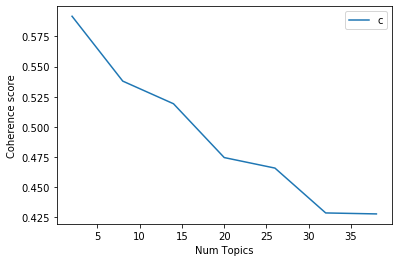

<Figure size 432x288 with 0 Axes>

In [0]:
#Model list and plot Coherence score against a number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
plt.savefig('Coherence score against a number of topics - MetaData', dpi = 500)

##Comparing the Coherence Scores per LDA Implementation